In [1]:
%matplotlib inline
import sys
import os
import time
start_time = time.time()

DATA_PATH = os.getenv('DATA_PATH')
CODE_PATH = os.getenv('CODE_PATH')
FIGURE_PATH = os.getenv('FIGURE_PATH')

sys.path.insert(0, os.path.join(CODE_PATH))

import pandas as pd
import numpy as np
import json
import re

import time

from src.load import EGRID, BA_DATA

import matplotlib.pyplot as plt

from calendar import month_abbr

import logging.config
logging.config.fileConfig(os.path.join(CODE_PATH, "src/logging.conf"))
logger = logging.getLogger(__name__)

In [2]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [6.99, 2.5]
plt.rcParams['grid.color'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.size'] = 10

import cmocean
cmap = cmocean.cm.cmap_d['phase']

In [3]:
# Make sure directory exists
os.makedirs(os.path.join(FIGURE_PATH, "si", "annualPlot"), exist_ok=True)

In [4]:
co2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_H.csv"), variable="CO2")
elec = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_E_H.csv"), variable="E")

In [5]:
def separate_imp_exp(data, ba):

    partners = data.get_trade_partners(ba)
    imp = 0.
    exp = 0.
    for ba2 in data.get_trade_partners(ba):
        imp += data.df.loc[:, data.KEY["ID"] % (ba,ba2)].apply(lambda x: min(x, 0))
        exp += data.df.loc[:, data.KEY["ID"] % (ba,ba2)].apply(lambda x: max(x, 0))
    return imp, exp


In [6]:
def annualPlot(elec, co2, ba, start=None, end=None, save=False):
    if start is None:
        start = pd.to_datetime("2016-01-01")
    if end is None:
        end = pd.to_datetime("2017-01-01")
    
    
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 12.5))
    for ax, data, scale in zip((ax1,ax2), [elec, co2], [1e-3, 1e-3]):
        df_plot = data.df.loc[start:end, :]
        ax.plot(df_plot.loc[:, data.get_cols(r=ba, field="D")] * scale, label="D")
        ax.plot(df_plot.loc[:, data.get_cols(r=ba, field="NG")] * scale, label="G", alpha=0.8)
#         ax.plot(df_plot.loc[:, data.get_cols(r=ba, field="TI")] * scale, label="I", alpha=0.7)
    
    # CO2i plot
    co2iD = (1000 * co2.df.loc[:, co2.get_cols(r=ba, field="D")].values.flatten()
             / elec.df.loc[:, elec.get_cols(r=ba, field="D")].values.flatten())
    co2iG = (1000 * co2.df.loc[:, co2.get_cols(r=ba, field="NG")].values.flatten()
             / elec.df.loc[:, elec.get_cols(r=ba, field="NG")].values.flatten())
    co2iD[co2iD>2000] = np.nan
    co2iG[co2iG>2000] = np.nan

#     co2iTI = (1000 * co2.df.loc[:, co2.get_cols(r=ba, field="TI")].values.flatten()
#              / elec.df.loc[:, elec.get_cols(r=ba, field="TI")].values.flatten())

    impC, expC = separate_imp_exp(co2, ba)
    impE, expE = separate_imp_exp(elec, ba)

#     co2i_exp = 1000 * expC / expE
    co2i_imp = 1000 * impC / impE
    
    ax1.plot(impE*1e-3, label = "Imp", alpha = 0.7)
    ax1.plot(expE*1e-3, label = "Exp", alpha = 0.7)
    
    ax2.plot(impC*1e-3, label = "Imp", alpha = 0.7)
    ax2.plot(expC*1e-3, label = "Exp", alpha = 0.7)
    
    ax3.plot(co2.df.index, co2iD, label="D")
    ax3.plot(co2.df.index, co2iG, label="G", alpha = 0.8)
    ax3.plot(co2.df.index, co2i_imp, label="Imp", alpha = 0.7)
    ax3.set_ylim(bottom=0.)
    
    for ax, data, scale in zip((ax4,ax5), [elec, co2], [1e-3,1e-3]):
        partners = data.get_trade_partners(ba)
        df_plot = data.df.loc[start:end, :]
        for ba2 in partners:
            ax.plot(df_plot.loc[:, data.KEY["ID"] % (ba, ba2)] * scale, label=ba2, alpha=.7)
    
    f.autofmt_xdate()
    ax1.set_title(ba)
    ax1.set_ylabel("Electricity (GWh)")
    ax2.set_ylabel("Carbon (ktons)")
    ax3.set_ylabel("Carbon intensity (kg/MWh)")
    ax4.set_ylabel("Electricity trade (MWh)")
    ax5.set_ylabel("Carbon trade (ktons)")
    
    for ax in [ax1, ax2, ax3, ax4,ax5]:
        ax.set_xlim([start-pd.Timedelta('3D'), end+pd.Timedelta('33D')])
        ax.legend(loc=7);
    f.tight_layout()
    
    if save:
        f.savefig(os.path.join(FIGURE_PATH, "si", "annualPlot",  "%s.pdf" % ba))
        plt.close(f)
    return (f, (ax1, ax2, ax3, ax4, ax5))

(<Figure size 2000x2500 with 5 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fe363578da0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fe36351e518>))

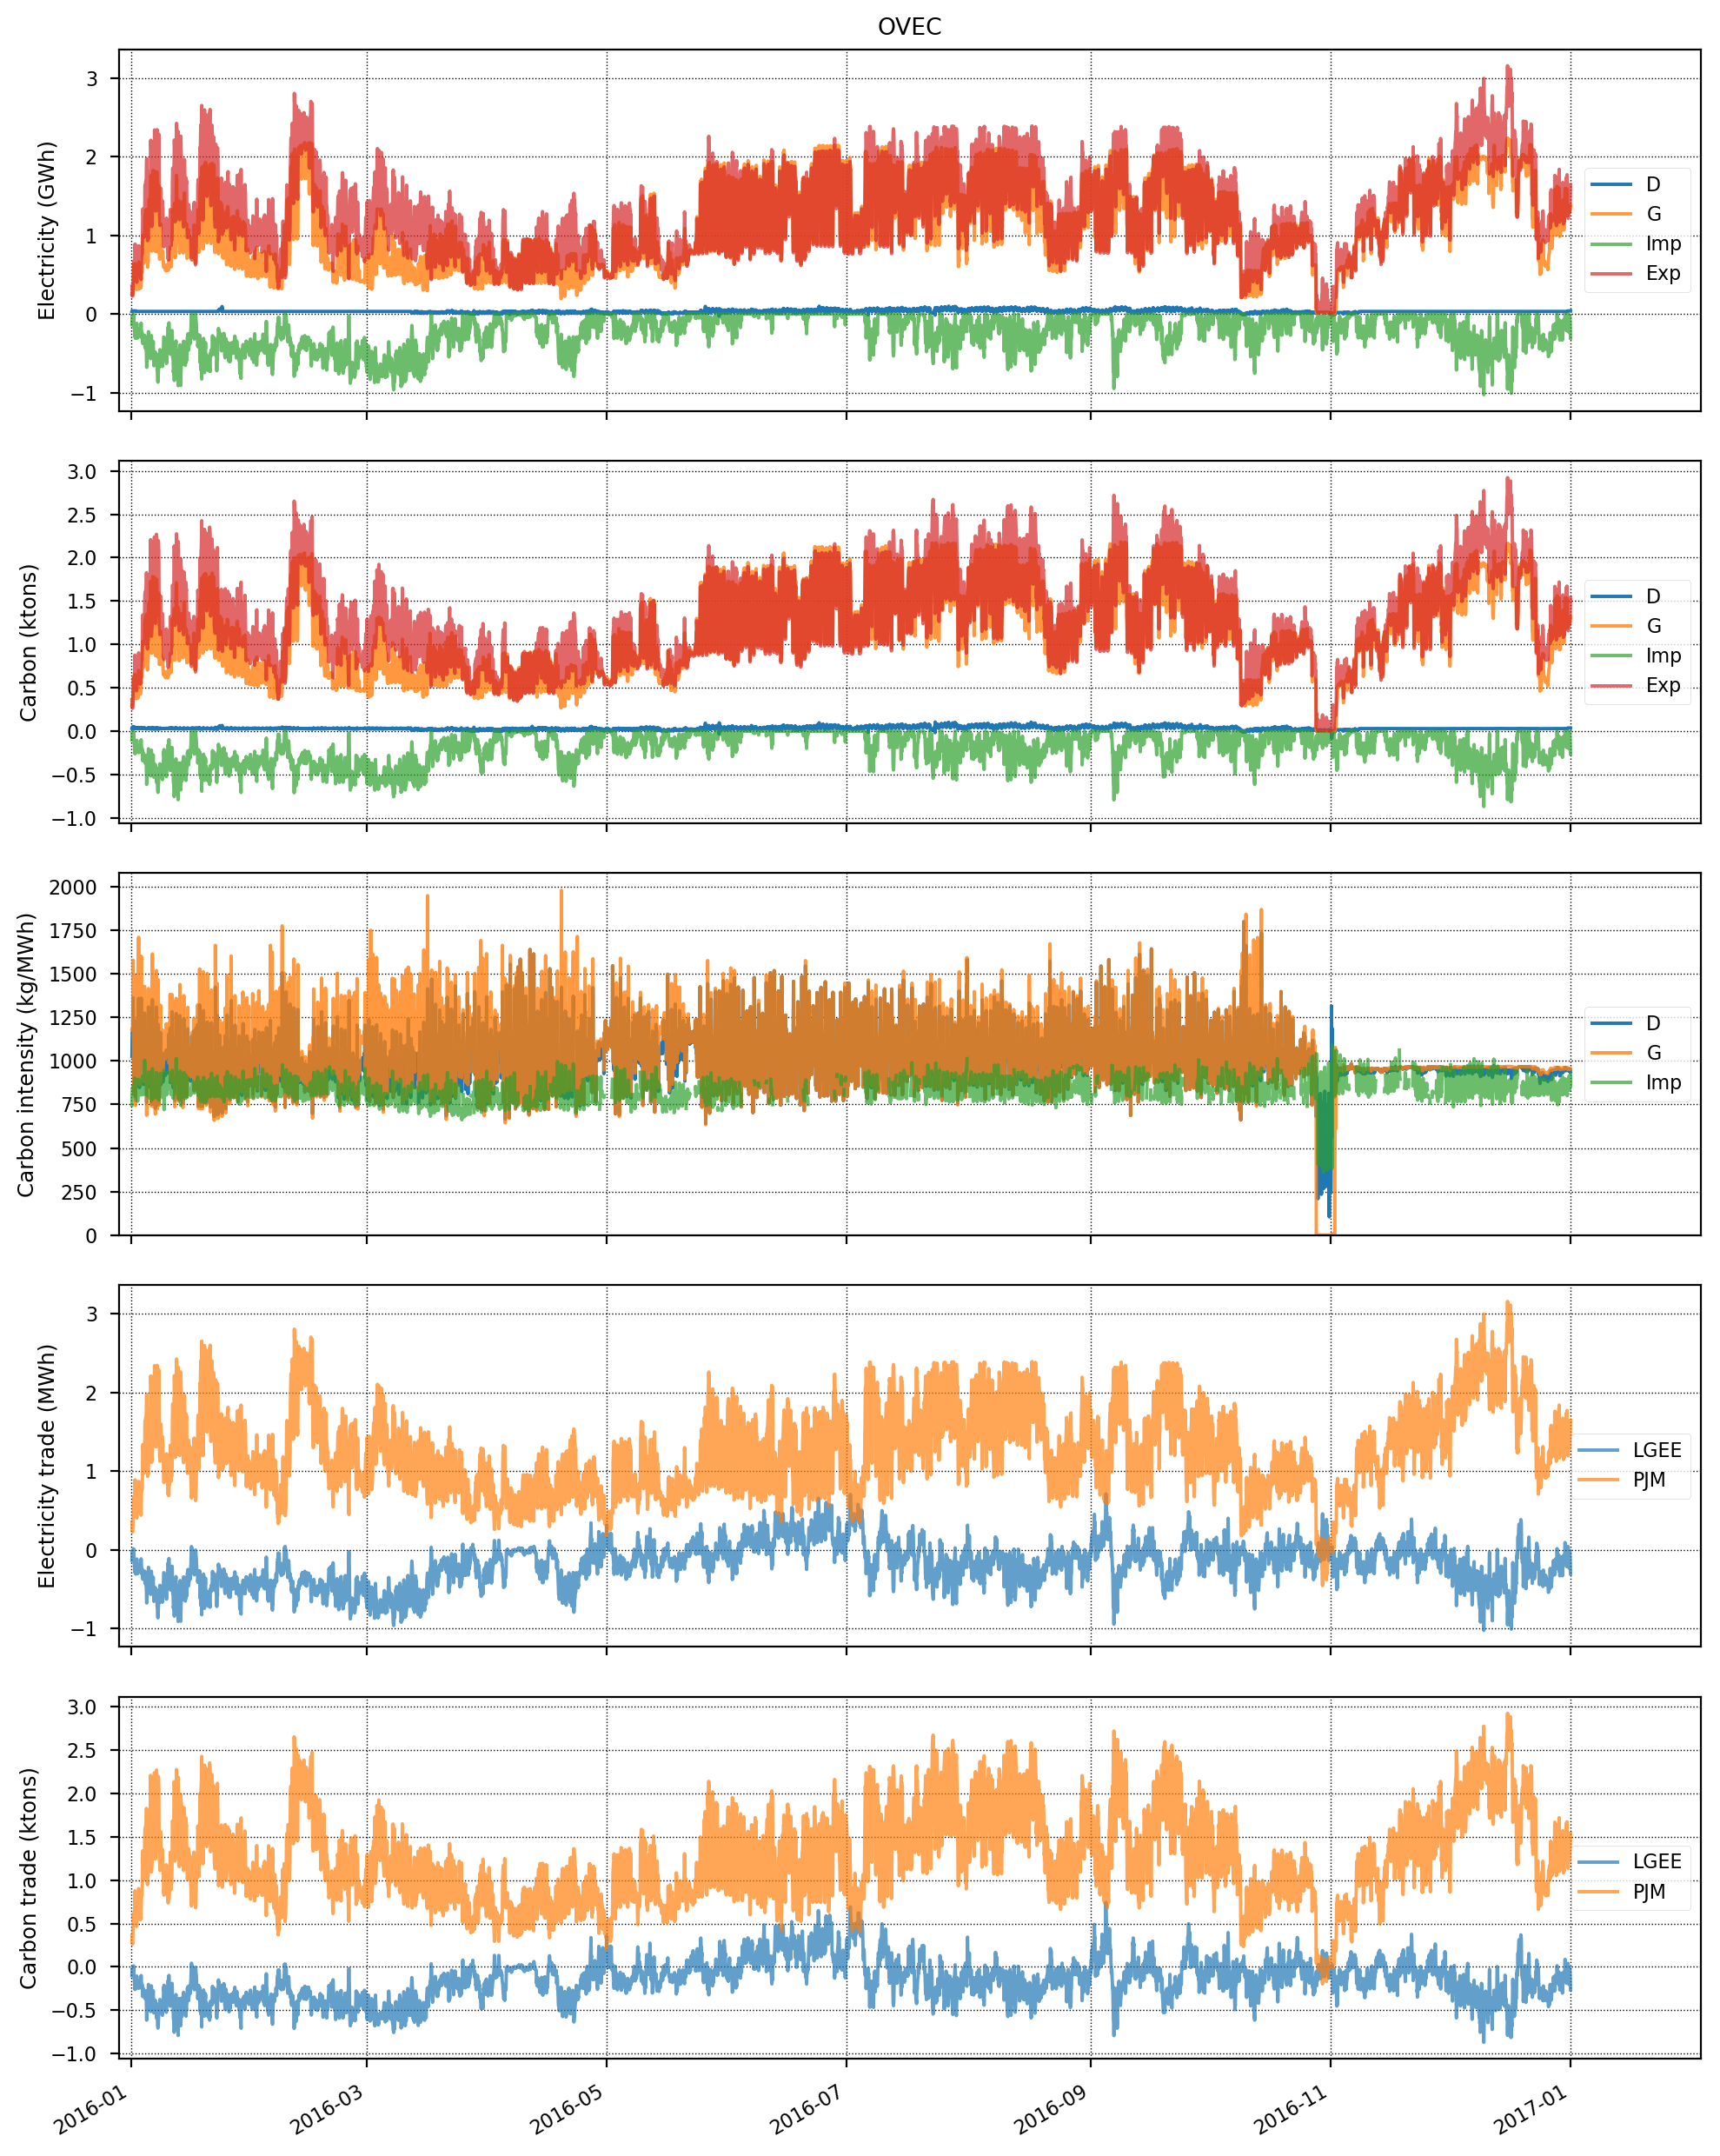

In [7]:
ba = "OVEC"
annualPlot(elec, co2, ba, save=False)


In [8]:
for ba in co2.regions:
    logger.info("%s: annual plot " % ba)
    annualPlot(elec, co2, ba, save=True)
    
# Special case: California plot - put the CARB number here as well
f, (ax1, ax2,ax3,ax4,ax5) = annualPlot(elec, co2, "CISO", save=False)
ax3.axhline(428, color='k')
ax3.text(pd.to_datetime('20160315'),450, 'CARB number for unspecified imports')
f.savefig(os.path.join(FIGURE_PATH, "si", "annualPlot",  "CISO.pdf"))
plt.close(f)

2019-11-16 19:41:14,461 - __main__ - INFO - AEC: annual plot 
2019-11-16 19:41:15,774 - __main__ - INFO - AECI: annual plot 
2019-11-16 19:41:17,194 - __main__ - INFO - AVA: annual plot 
2019-11-16 19:41:19,928 - __main__ - INFO - AZPS: annual plot 
2019-11-16 19:41:22,280 - __main__ - INFO - BANC: annual plot 
2019-11-16 19:41:23,747 - __main__ - INFO - BPAT: annual plot 
2019-11-16 19:41:26,038 - __main__ - INFO - CHPD: annual plot 
2019-11-16 19:41:27,631 - __main__ - INFO - CISO: annual plot 
2019-11-16 19:41:29,737 - __main__ - INFO - CPLE: annual plot 
2019-11-16 19:41:31,287 - __main__ - INFO - CPLW: annual plot 
2019-11-16 19:41:33,687 - __main__ - INFO - DEAA: annual plot 
2019-11-16 19:41:35,018 - __main__ - INFO - DOPD: annual plot 
2019-11-16 19:41:36,341 - __main__ - INFO - DUK: annual plot 
2019-11-16 19:41:38,394 - __main__ - INFO - EEI: annual plot 
2019-11-16 19:41:39,828 - __main__ - INFO - EPE: annual plot 
2019-11-16 19:41:41,175 - __main__ - INFO - ERCO: annual plo

In [9]:
co2_Y = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_Y.csv"), variable="CO2")
elec_Y = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_E_Y.csv"), variable="E")
so2_Y = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_SO2_Y.csv"), variable="SO2")
nox_Y = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_NOX_Y.csv"), variable="NOX")

ordered_bas = [col.split("_")[1] for col in co2_Y.df.loc[:, co2_Y.get_cols(field="D")]\
               .sort_values(by=co2_Y.df.index[0], axis=1, ascending=False).columns]
n = len(ordered_bas)//2

In [10]:
# Create SI text
figtex = r'''\begin{figure*}%[tbhp]
\centering
\includegraphics[width=17.79cm]{figures/annualPlot/'''
figtex2 = r'''.pdf}
\label{fig:annualPlot_'''

figtex3='''}
\caption{Hourly electricity and carbon data.}
\end{figure*}'''

with open(os.path.join(FIGURE_PATH, "si/annualPlot/annualPlot.tex"), "w") as fw:
    for ba in ordered_bas:
        fw.write(figtex+ba+figtex2+ba+figtex3+"\n")
        if ba == ordered_bas[n]:  # flush the floats so LaTeX doesn't complain
            fw.write(r'''\clearpage'''+"\n")

In [11]:
# Create SI table
tab_text1 = r'''\begin{table}\centering
\caption{Balancing area annual summary for demand (D) and generation (G) of electricity and carbon}
\begin{tabular}{lcccc}
&\multicolumn{2}{c}{Electricity}&\multicolumn{2}{c}{Carbon}\\
\hline
BA&D (TWh)&G (TWh)&D (Mtons)&G (Mtons)\\
\hline
'''
tab_text2 = r'''\hline
\end{tabular}
\qquad
\begin{tabular}{lcccc}
&\multicolumn{2}{c}{Electricity}&\multicolumn{2}{c}{Carbon}\\
\hline
BA&D (TWh)&G (TWh)&D (Mtons)&G (Mtons)\\
\hline
'''
tab_text3 = r'''\hline
\end{tabular}
\end{table}
'''
with open(os.path.join(FIGURE_PATH, "si/annualPlot/annualPlot_list1.tex"), "w") as fw:
    fw.write(tab_text1)
    for ba in ordered_bas[0:n]:
        fw.write("%s&%7.3g&%7.3g&%7.3g&%7.3g%s\n" % (
            ba,
            elec_Y.df.iloc[0][elec_Y.get_cols(ba, field="D")]*1e-6,
            elec_Y.df.iloc[0][elec_Y.get_cols(ba, field="NG")]*1e-6,
            co2_Y.df.iloc[0][co2_Y.get_cols(ba, field="D")]*1e-6,
            co2_Y.df.iloc[0][co2_Y.get_cols(ba, field="NG")]*1e-6,
            r"\\"))
    fw.write(tab_text2)
    for ba in ordered_bas[n:]:
        fw.write("%s&%7.3g&%7.3g&%7.3g&%7.3g%s\n" % (
            ba,
            elec_Y.df.iloc[0][elec_Y.get_cols(ba, field="D")]*1e-6,
            elec_Y.df.iloc[0][elec_Y.get_cols(ba, field="NG")]*1e-6,
            co2_Y.df.iloc[0][co2_Y.get_cols(ba, field="D")]*1e-6,
            co2_Y.df.iloc[0][co2_Y.get_cols(ba, field="NG")]*1e-6,
            r"\\"))
    fw.write(tab_text3)

tab_text1 = r'''\begin{table}\centering
\caption{Balancing area annual summary for demand (D) and generation (G) of sulfur dioxide and nitrogen oxides}
\begin{tabular}{lcccc}
&\multicolumn{2}{c}{Sulfur dioxide}&\multicolumn{2}{c}{Nitrogen oxides}\\
\hline
BA&D (ktons)&G (ktons)&D (ktons)&G (ktons)\\
\hline
'''
tab_text2 = r'''\hline
\end{tabular}
\qquad
\begin{tabular}{lcccc}
&\multicolumn{2}{c}{Sulfur dioxide}&\multicolumn{2}{c}{Nitrogen oxides}\\
\hline
BA&D (ktons)&G (ktons)&D (ktons)&G (ktons)\\
\hline
'''
with open(os.path.join(FIGURE_PATH, "si/annualPlot/annualPlot_list2.tex"), "w") as fw:
    fw.write(tab_text1)
    for ba in ordered_bas[0:n]:
        fw.write("%s&%7.3g&%7.3g&%7.3g&%7.3g%s\n" % (
            ba,
            so2_Y.df.iloc[0][so2_Y.get_cols(ba, field="D")]*1e-3,
            so2_Y.df.iloc[0][so2_Y.get_cols(ba, field="NG")]*1e-3,
            nox_Y.df.iloc[0][nox_Y.get_cols(ba, field="D")]*1e-3,
            nox_Y.df.iloc[0][nox_Y.get_cols(ba, field="NG")]*1e-3,
            r"\\"))
    fw.write(tab_text2)
    for ba in ordered_bas[n:]:
        fw.write("%s&%7.3g&%7.3g&%7.3g&%7.3g%s\n" % (
            ba,
            so2_Y.df.iloc[0][so2_Y.get_cols(ba, field="D")]*1e-3,
            so2_Y.df.iloc[0][so2_Y.get_cols(ba, field="NG")]*1e-3,
            nox_Y.df.iloc[0][nox_Y.get_cols(ba, field="D")]*1e-3,
            nox_Y.df.iloc[0][nox_Y.get_cols(ba, field="NG")]*1e-3,
            r"\\"))
    fw.write(tab_text3)

In [12]:
# dummy file for the Makefile
with open(os.path.join(FIGURE_PATH, "si", "annualPlot", "dummy"), "w") as fw:
    fw.write("done")
logger.info("Notebook execution time: %.2f seconds" % (time.time()-start_time))

2019-11-16 19:43:03,687 - __main__ - INFO - Notebook execution time: 116.56 seconds
